In [4]:
import sqlite3
import geopandas
import pandas
import torch
import shapely.wkb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# connect to db
conn = sqlite3.connect('db.sqlite3')

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

class AirModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = torch.nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [5]:
# load Ingresos Programa de Salud Mental por mes y año for RM
# take the average per month
data = conn.execute("""
select sum(data.value), unixepoch(data.year || '-' || (
    case data.cohort
        when 'Enero' then '01'
        when 'Febrero' then '02'
        when 'Marzo' then '03'
        when 'Abril' then '04'
        when 'Mayo' then '05'
        when 'Junio' then '06'
        when 'Julio' then '07'
        when 'Agosto' then '08'
        when 'Septiembre' then '09'
        when 'Octubre' then '10'
        when 'Noviembre' then '11'
        when 'Diciembre' then '12'
        else 1
    end) || '-01') as unixepoch
from data
join report on data.report_id = report.id
join establishment on data.establishment_id = establishment.id
join commune on establishment.commune_id = commune.id
where report.description = 'Ingresos Programa de Salud Mental por mes y año'
  and commune.name = 'PENALOLEN'
group by unixepoch
order by unixepoch
""").fetchall()

# drop unixtimestamp
data = pandas.DataFrame(data, columns=['value', 'unixepoch']).drop(columns=['unixepoch'])
data

# # scale
scaler = MinMaxScaler()
# scaler = StandardScaler()
data[["value"]] = scaler.fit_transform(data[["value"]])
data

,value
0,0.517196
1,0.354497
2,0.652116
3,0.685185
4,0.732804
...,...
76,0.543651
77,0.441799
78,0.620370
79,0.537037


/var/folders/_y/3sf4zcts77qc08tdxp77p9mm0000gn/T/ipykernel_39679/4238273075.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  return torch.tensor(X), torch.tensor(y)
/var/folders/_y/3sf4zcts77qc08tdxp77p9mm0000gn/T/ipykernel_39679/2798896758.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
/var/folders/_y/3sf4zcts77qc08tdxp77p9mm0000gn/T/ipykernel_39679/2798896758.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 0.6295, test RMSE 0.7599
Epoch 100: train RMSE 0.1606, test RMSE 0.1548
Epoch 200: train RMSE 0.1569, test RMSE 0.1517
Epoch 300: train RMSE 0.1537, test RMSE 0.1524
Epoch 400: train RMSE 0.1371, test RMSE 0.1759
Epoch 500: train RMSE 0.1266, test RMSE 0.2046
Epoch 600: train RMSE 0.1201, test RMSE 0.2112
Epoch 700: train RMSE 0.1164, test RMSE 0.2080
Epoch 800: train RMSE 0.1136, test RMSE 0.2013
Epoch 900: train RMSE 0.1112, test RMSE 0.2023
Epoch 1000: train RMSE 0.1065, test RMSE 0.2030
Epoch 1100: train RMSE 0.1027, test RMSE 0.2156
Epoch 1200: train RMSE 0.0979, test RMSE 0.2142
Epoch 1300: train RMSE 0.0939, test RMSE 0.2223
Epoch 1400: train RMSE 0.0902, test RMSE 0.2266
Epoch 1500: train RMSE 0.0865, test RMSE 0.2265
Epoch 1600: train RMSE 0.0845, test RMSE 0.2322
Epoch 1700: train RMSE 0.0832, test RMSE 0.2302
Epoch 1800: train RMSE 0.0807, test RMSE 0.2314
Epoch 1900: train RMSE 0.0802, test RMSE 0.2347
Epoch 2000: train RMSE 0.0779, test RMSE 0.2370


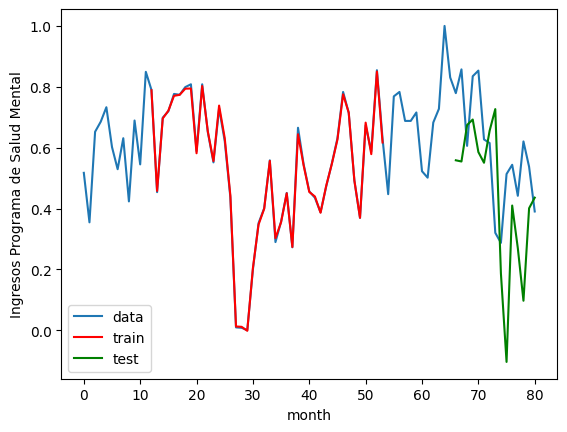

In [6]:
# test data
timeseries = data.values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

lookback = 12
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

model = AirModel()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2001
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.xlabel('month')
plt.ylabel('Ingresos Programa de Salud Mental')
plt.legend(['data', 'train', 'test'])
plt.show()

/var/folders/_y/3sf4zcts77qc08tdxp77p9mm0000gn/T/ipykernel_39679/3316292031.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))


Epoch 0: train RMSE 0.6189
Epoch 100: train RMSE 0.1563
Epoch 200: train RMSE 0.1557


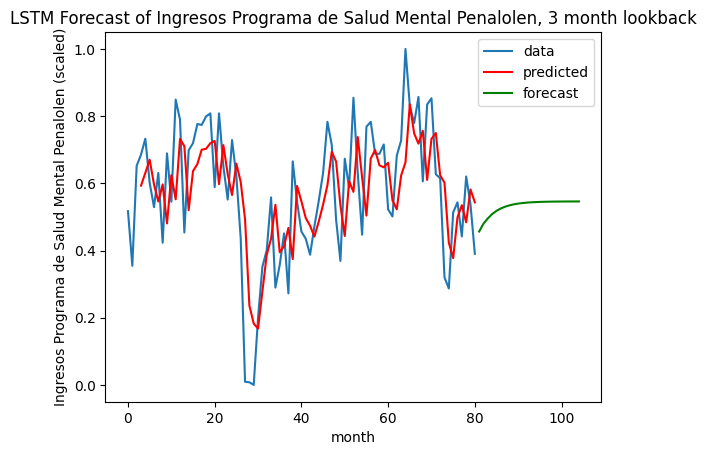

In [7]:
# full data and forecast
timeseries = data.values.astype('float32')

train_size = int(len(timeseries))

lookback = 3
X_train, y_train = create_dataset(timeseries, lookback=lookback)

model = AirModel()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 201
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
    print("Epoch %d: train RMSE %.4f" % (epoch, train_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]

    # forecast
    forecast_steps = 24
    input_seq = torch.tensor(timeseries[-lookback:]).unsqueeze(0)
    forecast = []
    for _ in range(forecast_steps):
        with torch.no_grad():
            next_val = model(input_seq)
        forecast.append(next_val[0, -1, 0].item())
        input_seq = torch.cat((input_seq[:, 1:, :], next_val[:, -1:, :]), dim=1)
    forecast = np.array(forecast)

# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(range(len(timeseries), len(timeseries)+forecast_steps), forecast, c='g')
plt.title("LSTM Forecast of Ingresos Programa de Salud Mental Penalolen, 3 month lookback")
plt.xlabel('month')
plt.ylabel('Ingresos Programa de Salud Mental Penalolen (scaled)')
plt.legend(['data', 'predicted', 'forecast'])
plt.show()

/var/folders/_y/3sf4zcts77qc08tdxp77p9mm0000gn/T/ipykernel_39679/3832806991.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))


Epoch 0: train RMSE 0.7107
Epoch 100: train RMSE 0.1485
Epoch 200: train RMSE 0.1454


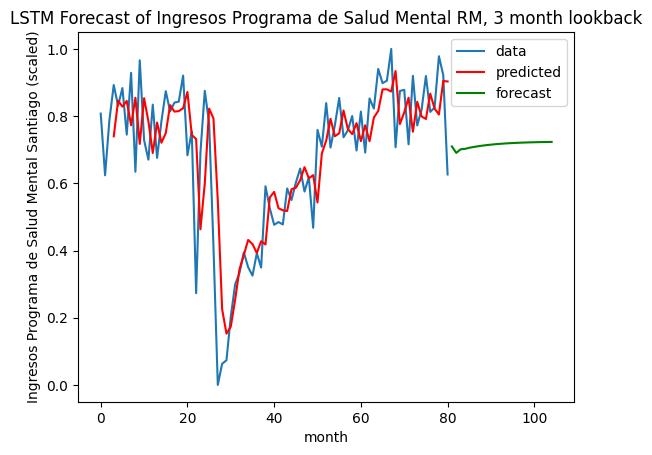

In [8]:
# RM
# load Ingresos Programa de Salud Mental por mes y año for RM
# take the average per month
data = conn.execute("""
select sum(data.value), unixepoch(data.year || '-' || (
    case data.cohort
        when 'Enero' then '01'
        when 'Febrero' then '02'
        when 'Marzo' then '03'
        when 'Abril' then '04'
        when 'Mayo' then '05'
        when 'Junio' then '06'
        when 'Julio' then '07'
        when 'Agosto' then '08'
        when 'Septiembre' then '09'
        when 'Octubre' then '10'
        when 'Noviembre' then '11'
        when 'Diciembre' then '12'
        else 1
    end) || '-01') as unixepoch
from data
join report on data.report_id = report.id
join establishment on data.establishment_id = establishment.id
join commune on establishment.commune_id = commune.id
where report.description = 'Ingresos Programa de Salud Mental por mes y año'
  and commune.region = 'REGION METROPOLITANA DE SANTIAGO'
group by unixepoch
order by unixepoch
""").fetchall()

# drop unixtimestamp
data = pandas.DataFrame(data, columns=['value', 'unixepoch']).drop(columns=['unixepoch'])
data

# # scale
scaler = MinMaxScaler()
# scaler = StandardScaler()
data[["value"]] = scaler.fit_transform(data[["value"]])
data

# full data and forecast
timeseries = data.values.astype('float32')

train_size = int(len(timeseries))

lookback = 3
X_train, y_train = create_dataset(timeseries, lookback=lookback)

model = AirModel()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 201
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
    print("Epoch %d: train RMSE %.4f" % (epoch, train_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]

    # forecast
    forecast_steps = 24
    input_seq = torch.tensor(timeseries[-lookback:]).unsqueeze(0)
    forecast = []
    for _ in range(forecast_steps):
        with torch.no_grad():
            next_val = model(input_seq)
        forecast.append(next_val[0, -1, 0].item())
        input_seq = torch.cat((input_seq[:, 1:, :], next_val[:, -1:, :]), dim=1)
    forecast = np.array(forecast)

# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(range(len(timeseries), len(timeseries)+forecast_steps), forecast, c='g')
plt.title("LSTM Forecast of Ingresos Programa de Salud Mental RM, 3 month lookback")
plt.xlabel('month')
plt.ylabel('Ingresos Programa de Salud Mental Santiago (scaled)')
plt.legend(['data', 'predicted', 'forecast'])
plt.show()